# Assignment 5
# Z1857655
# Akram Shaik

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import pathlib

import matplotlib.pyplot as plt
%matplotlib inline
# import image datagenerator to apply data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# importing hub to load mobilenet model
import tensorflow_hub as hub

from tensorflow.keras import datasets, layers, models
# importing keras earlystopping to avoid overfitting
from keras.callbacks import EarlyStopping
#importing optimizers required to be tested
from tensorflow.keras.optimizers import RMSprop, SGD, Adam

from keras.layers import Dense, Flatten
from keras.models import Model
# importing resnet50v2 and resnet101v2 models to load and apply feature extraction
from keras.applications.resnet_v2 import ResNet50V2, ResNet101V2

In [2]:
_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

print(path_to_zip)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

#path of training data images
train_dir = os.path.join(PATH, 'train')

#path of validated data images
validation_dir = os.path.join(PATH, 'validation')

68608000/68606236 [==============================] - 1s 0us/step
/root/.keras/datasets/cats_and_dogs.zip


In [3]:
#train_dir

In [4]:
train_dir = pathlib.Path(train_dir)
train_image_count = len(list(train_dir.glob('*/*.jpg')))
print(train_image_count)

validation_dir = pathlib.Path(validation_dir)
val_image_count = len(list(validation_dir.glob('*/*.jpg')))
print(val_image_count)

2000
1000


In [5]:
# All images will be rescaled, rotated, width and height shifted, flipped horizontally and zoom range is set.
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=45, width_shift_range=.15,height_shift_range=.15,horizontal_flip=True,
                                   zoom_range=0.5)
# validation data does not need to be created in different forms so to be as a real data but scaling is applied
val_datagen = ImageDataGenerator(rescale=1./255)

# Training data is passed from train data path in batches of 32 by shuffling with a target size of 224 and setting classmode to binary as being abinary classification
train_generator = train_datagen.flow_from_directory( train_dir, target_size=(224, 224), batch_size=32, shuffle= True, class_mode='binary')

# validation data is passed from validation data path in batches of 32 by shuffling with a target size of 224 and setting classmode to binary as being abinary classification
validation_generator = val_datagen.flow_from_directory(validation_dir, target_size=(224, 224), batch_size=32, shuffle= True, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [54]:
# model is created with multiple convolutional layers with different number of filters, with relu activation and maxpooling
# dopout is also applied to regularize  and dense layers are also added after flattening the data. 
model = models.Sequential([
                           layers.Conv2D(16, (3, 3),kernel_initializer='glorot_uniform', input_shape=(224, 224, 3), padding='SAME'),
                           layers.LeakyReLU(),
                           # max pooling is used to downsample the data and use max value from the size of pool where max value has useful information from any grid of its size 
                           layers.MaxPooling2D((2, 2)),
                           layers.Conv2D(32, (3, 3),kernel_initializer='glorot_uniform', padding='SAME'),
                           layers.LeakyReLU(),
                           layers.MaxPooling2D((2, 2)),
                           #layers.Dropout(0.2),
                           layers.Conv2D(64, (3, 3),kernel_initializer='glorot_uniform', padding='SAME'),
                           layers.LeakyReLU(),
                           layers.Dropout(0.3),
                           layers.Conv2D(128, (3, 3), kernel_initializer='glorot_uniform',padding='SAME'),
                           layers.LeakyReLU(),
                           layers.MaxPooling2D((2, 2)),
                           layers.Dropout(0.3),
                           #layers.Conv2D(256, (3, 3), padding='SAME'),
                           #layers.LeakyReLU(),
                           #layers.MaxPooling2D((2, 2)),
                           #layers.Dropout(0.2),
                           # falltening the layers to bring it in one dimension
                           layers.Flatten(),
                           layers.Dense(512,kernel_initializer='glorot_uniform'),
                           layers.LeakyReLU(),
                           # creating last layer with 1 nodes as the number of classes can be decided between 0 and 1
                           layers.Dense(1)
                           ])

In [55]:
# printing summary to check number of parameters 
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 112, 112, 32)      0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 56, 56, 64)       

In [56]:
# compiling model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=Adam(0.0001),metrics=['accuracy'])

In [57]:
batch_size = 32
epochs = 80
# using early stopping to monitor validation data's loss value with mode min as we need loss as minimum as possible and patience helps in keeping track limit 
# if the loss is increasing for 5 epoch the model stops using call backs 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [58]:
# function to plot loss and accuracy of models
def plot_acc_loss(history,epochs):
  # Plot training and validation loss per epoch
  plt.plot(np.array(range(epochs)), history.history['loss'], label='train_loss')
  plt.plot(np.array(range(epochs)), history.history['val_loss'], label='val_loss')
  plt.title('Training and validation loss')
  plt.legend(loc='upper right')

  plt.figure()
  
  # Plot training and validation accuracy per epoch
  plt.plot(np.array(range(epochs)), history.history['accuracy'],label='train_acc')
  plt.plot(np.array(range(epochs)), history.history['val_accuracy'],label='val_acc') 
  plt.title('Training and validation accuracy')
  plt.legend(loc='lower right')

In [59]:
# fitting model with generated train data and 50 epoch with batch size of 32 and generated validation data with a callback function using earlystopping by keeping val loss in track
#history = model.fit(train_generator, epochs=epochs, batch_size=batch_size,verbose=2,validation_data=validation_generator, callbacks=[es])
history = model.fit(train_generator, epochs=epochs, batch_size=batch_size,verbose=2,validation_data=validation_generator)

Epoch 1/80
63/63 - 28s - loss: 0.7892 - accuracy: 0.5015 - val_loss: 0.6915 - val_accuracy: 0.5000
Epoch 2/80
63/63 - 29s - loss: 0.6826 - accuracy: 0.5335 - val_loss: 0.6866 - val_accuracy: 0.5040
Epoch 3/80
63/63 - 30s - loss: 0.6633 - accuracy: 0.5585 - val_loss: 0.6505 - val_accuracy: 0.5650
Epoch 4/80
63/63 - 29s - loss: 0.6666 - accuracy: 0.5680 - val_loss: 0.6383 - val_accuracy: 0.6190
Epoch 5/80
63/63 - 29s - loss: 0.6514 - accuracy: 0.5840 - val_loss: 0.6388 - val_accuracy: 0.6350
Epoch 6/80
63/63 - 29s - loss: 0.6370 - accuracy: 0.6065 - val_loss: 0.6459 - val_accuracy: 0.6590
Epoch 7/80
63/63 - 29s - loss: 0.6361 - accuracy: 0.6155 - val_loss: 0.7199 - val_accuracy: 0.6140
Epoch 8/80
63/63 - 29s - loss: 0.6201 - accuracy: 0.6290 - val_loss: 0.6623 - val_accuracy: 0.6320
Epoch 9/80
63/63 - 29s - loss: 0.6180 - accuracy: 0.6185 - val_loss: 0.7138 - val_accuracy: 0.6500
Epoch 10/80
63/63 - 29s - loss: 0.6177 - accuracy: 0.6250 - val_loss: 0.6604 - val_accuracy: 0.6470
Epoch 11/

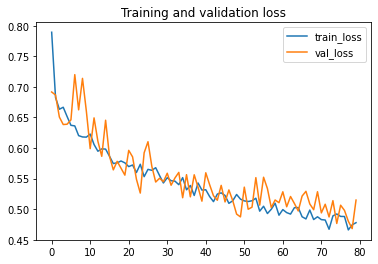

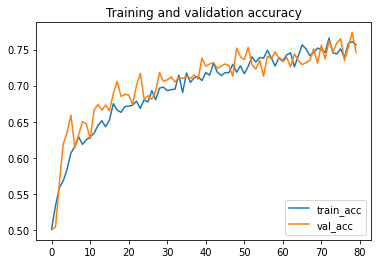

In [60]:
# calling function to plot loss and accuracy from the history object after fitting the model
plot_acc_loss(history,len(history.history['loss']))

### Here we see how close the training and validation accuracy is with 80 epochs, it has been tested with different epochs and different parameters, activation function and dropout rate. Initially validation accuracy is better than training because the sample images generated with data augentation were complex and the modelis trained on them. So in validation having simple images caused the validation accuracy to be better than training but by decreasing learning rate and increasing epoch I was able to get them as close as possible with good accuracy.

# **Question 3**

In [71]:
# mobile net model which is trained on imagenet with no maxpooling and relatively does not high depth comared to other models but with increase in epochs it gives better or same accuracy 
# here we use transfer learning by making trainable as false to not train the weights  
mobilenet_model = tf.keras.Sequential([
                                       hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", input_shape=(224, 224, 3), trainable=False),  # Can be True, see below.
                                       layers.Dense(1)
                                       ])
mobilenet_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

In [72]:
mobilenet_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [73]:
#trining with 50 epochs to not overfit the model
epochs = 50
# if the loss is increasing for 1 epoch the model stops using call backs 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=0)

In [74]:
#mobilenet model if fitted with same train and validation data generated
#mobilenet_history = mobilenet_model.fit(train_generator, epochs=epochs, batch_size=32,verbose=2,validation_data=validation_generator, callbacks=[es])
mobilenet_history = mobilenet_model.fit(train_generator, epochs=epochs, batch_size=32,verbose=2,validation_data=validation_generator)

Epoch 1/50
63/63 - 27s - loss: 0.2760 - accuracy: 0.8780 - val_loss: 0.0932 - val_accuracy: 0.9740
Epoch 2/50
63/63 - 26s - loss: 0.1390 - accuracy: 0.9430 - val_loss: 0.0651 - val_accuracy: 0.9850
Epoch 3/50
63/63 - 27s - loss: 0.1214 - accuracy: 0.9485 - val_loss: 0.0630 - val_accuracy: 0.9860
Epoch 4/50
63/63 - 27s - loss: 0.1147 - accuracy: 0.9535 - val_loss: 0.0517 - val_accuracy: 0.9880
Epoch 5/50
63/63 - 27s - loss: 0.1049 - accuracy: 0.9610 - val_loss: 0.0487 - val_accuracy: 0.9890
Epoch 6/50
63/63 - 26s - loss: 0.1139 - accuracy: 0.9510 - val_loss: 0.0461 - val_accuracy: 0.9890
Epoch 7/50
63/63 - 27s - loss: 0.1130 - accuracy: 0.9480 - val_loss: 0.0439 - val_accuracy: 0.9890
Epoch 8/50
63/63 - 26s - loss: 0.1018 - accuracy: 0.9570 - val_loss: 0.0425 - val_accuracy: 0.9860
Epoch 9/50
63/63 - 26s - loss: 0.0983 - accuracy: 0.9545 - val_loss: 0.0494 - val_accuracy: 0.9890
Epoch 10/50
63/63 - 26s - loss: 0.1100 - accuracy: 0.9535 - val_loss: 0.0417 - val_accuracy: 0.9930
Epoch 11/

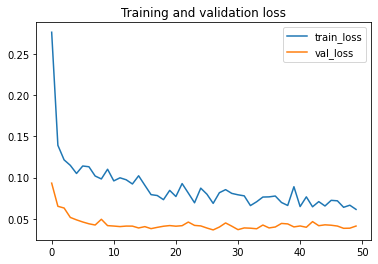

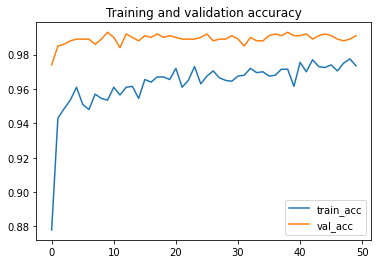

In [75]:
# Plot training and validation accuracy per epoch
plot_acc_loss(mobilenet_history,epochs)

### with 5 epochs we got 98.7 % accuracy on validation data, we see that loss is steadily decreasing and accuracy is steadily inncreasing. But the gap between them was very high because of which model might not perform well on new data, to reduce it I increased the epochs to 50 where the gap got reduced.The validation curve is better than training curve because model is trainied on larger imagenet dataset involving many complicated or high varience data it became easy for model to predict small and simple data of validation. More and complex new data could be used to test the difference.

# **Question 4** - Resnet50v2 and Resnet101v2

In [87]:
# resnet50v2 model is trained on same imagenet dataset but has more depth than mobilenet model and also parameters to train  
resnet = ResNet50V2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

# setting weights of the pretrained model to be false so to not train again
for layer in resnet.layers:
  layer.trainable = False

# flattening the ouput of renet data so to generate binary classification else it can predict 1000 classes
flat= Flatten()(resnet.output)
output_layer = Dense(1)(flat)

#creating model with resnet layers and newly created output layer
resnet50_model = Model(inputs=resnet.input, outputs=output_layer)
#compiling model
resnet50_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=Adam(),metrics=['accuracy'])

In [88]:
resnet50_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [89]:
epochs = 30
# fitting the model with generated train and val data images
resnet50_history = resnet50_model.fit(train_generator, epochs=epochs, batch_size = 32,verbose=2,validation_data=validation_generator)

Epoch 1/30
63/63 - 29s - loss: 1.0338 - accuracy: 0.9080 - val_loss: 0.1394 - val_accuracy: 0.9860
Epoch 2/30
63/63 - 28s - loss: 0.6808 - accuracy: 0.9415 - val_loss: 0.2075 - val_accuracy: 0.9820
Epoch 3/30
63/63 - 28s - loss: 0.6414 - accuracy: 0.9505 - val_loss: 0.2772 - val_accuracy: 0.9810
Epoch 4/30
63/63 - 28s - loss: 0.8272 - accuracy: 0.9485 - val_loss: 0.3957 - val_accuracy: 0.9790
Epoch 5/30
63/63 - 28s - loss: 0.8141 - accuracy: 0.9455 - val_loss: 0.2395 - val_accuracy: 0.9820
Epoch 6/30
63/63 - 28s - loss: 0.7268 - accuracy: 0.9510 - val_loss: 0.2982 - val_accuracy: 0.9810
Epoch 7/30
63/63 - 28s - loss: 0.7963 - accuracy: 0.9555 - val_loss: 0.3806 - val_accuracy: 0.9800
Epoch 8/30
63/63 - 28s - loss: 0.8056 - accuracy: 0.9555 - val_loss: 0.5710 - val_accuracy: 0.9770
Epoch 9/30
63/63 - 28s - loss: 0.5755 - accuracy: 0.9630 - val_loss: 0.3744 - val_accuracy: 0.9830
Epoch 10/30
63/63 - 28s - loss: 0.6697 - accuracy: 0.9565 - val_loss: 0.2568 - val_accuracy: 0.9820
Epoch 11/

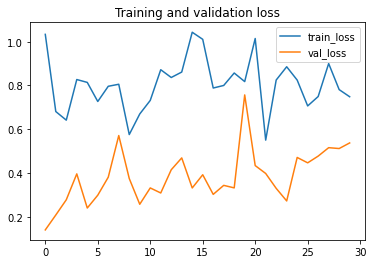

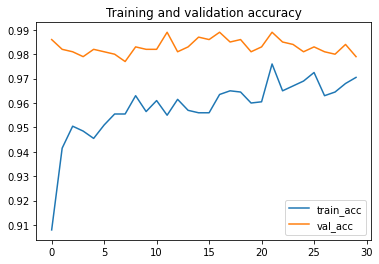

In [90]:
plot_acc_loss(resnet50_history,epochs)

### with 5 epochs we got 98.4 % accuracy on validation data, this is similar to mobilenet for known reasons of having deeper network with more training parameters. Similar to mobilenetv2, resnet50v2 model is also trainied on larger imagenet dataset involving many complicated or high varience data it became easy for model to predict small and simple data of validation. But resnet model is also similar in reducing the train and validation gap.

In [83]:
# resnet101 model is also trained on imagenet dataset but with more layers than resnet50 or we can say it has twice the number of layers
resnet101 = ResNet101V2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
# making trainable as false in all layers
for layer in resnet101.layers:
  layer.trainable = False
# creating final output layer 2 classify between 2 classes using softmax
flat= Flatten()(resnet101.output)
output_layer = Dense(1)(flat)

# model is created with resnet101 layers and final output layer created
resnet101_model = Model(inputs=resnet101.input, outputs=output_layer)
# compiling the model
resnet101_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=Adam(),metrics=['accuracy'])
# fitting the model on same train and val generated data

In [84]:
resnet101_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [85]:
epochs=30
resnet101_history = resnet101_model.fit( train_generator, epochs = epochs, batch_size = 32, verbose=2, validation_data = validation_generator)

Epoch 1/30
63/63 - 32s - loss: 0.8530 - accuracy: 0.9155 - val_loss: 0.3142 - val_accuracy: 0.9800
Epoch 2/30
63/63 - 31s - loss: 0.8097 - accuracy: 0.9460 - val_loss: 0.4101 - val_accuracy: 0.9800
Epoch 3/30
63/63 - 31s - loss: 0.8804 - accuracy: 0.9475 - val_loss: 0.3692 - val_accuracy: 0.9800
Epoch 4/30
63/63 - 31s - loss: 0.7880 - accuracy: 0.9520 - val_loss: 0.5455 - val_accuracy: 0.9820
Epoch 5/30
63/63 - 31s - loss: 0.9735 - accuracy: 0.9520 - val_loss: 0.3300 - val_accuracy: 0.9820
Epoch 6/30
63/63 - 31s - loss: 0.5609 - accuracy: 0.9675 - val_loss: 0.4505 - val_accuracy: 0.9790
Epoch 7/30
63/63 - 31s - loss: 0.7707 - accuracy: 0.9595 - val_loss: 0.3117 - val_accuracy: 0.9840
Epoch 8/30
63/63 - 31s - loss: 0.8510 - accuracy: 0.9565 - val_loss: 0.8227 - val_accuracy: 0.9790
Epoch 9/30
63/63 - 31s - loss: 0.8384 - accuracy: 0.9645 - val_loss: 0.2974 - val_accuracy: 0.9860
Epoch 10/30
63/63 - 31s - loss: 0.6410 - accuracy: 0.9665 - val_loss: 0.3876 - val_accuracy: 0.9880
Epoch 11/

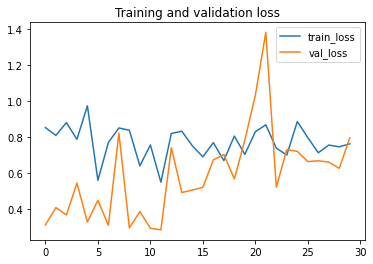

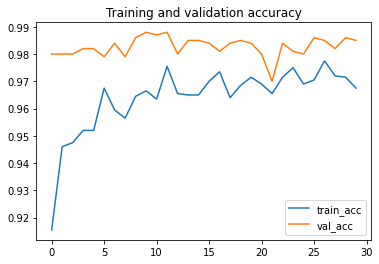

In [86]:
plot_acc_loss(resnet101_history,epochs)

### having difference of depth and trained parametrs from resnet50 and mobilenet model, resnet101 model gave almost same accuracy but having different and deep structure there was lot of training hapenning due to which slight change in validation data was effecting the accuracy and loss alot.

# Of all MobileNet model was best with accuracy and loss with less number of layers and wights to train. But it needs more epochs to achive that.